### Install/Unzip anything needed

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-if2h2bmj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-if2h2bmj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=14b5864ef82e3db17cfc88848e4f669f42c062edd3a9be61f2879ddb7288400b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ermilsr/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/CV/final/S1.zip"

###Code for using SAM

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) # sorting segmentation masks based on the area
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    i = 0
    for ann in sorted_anns:
        # i += 1
        # if i != 4:
        #   continue
        m = ann['segmentation']
        print(ann['area'])
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
from google.colab.patches import cv2_imshow
sam = sam_model_registry["vit_h"](checkpoint="/content/drive/MyDrive/Colab Notebooks/CV/final/sam_vit_h_4b8939.pth")
sam.to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam)

gray = cv2.imread('/content/S1/02/4.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

masks = mask_generator.generate(image)

1558


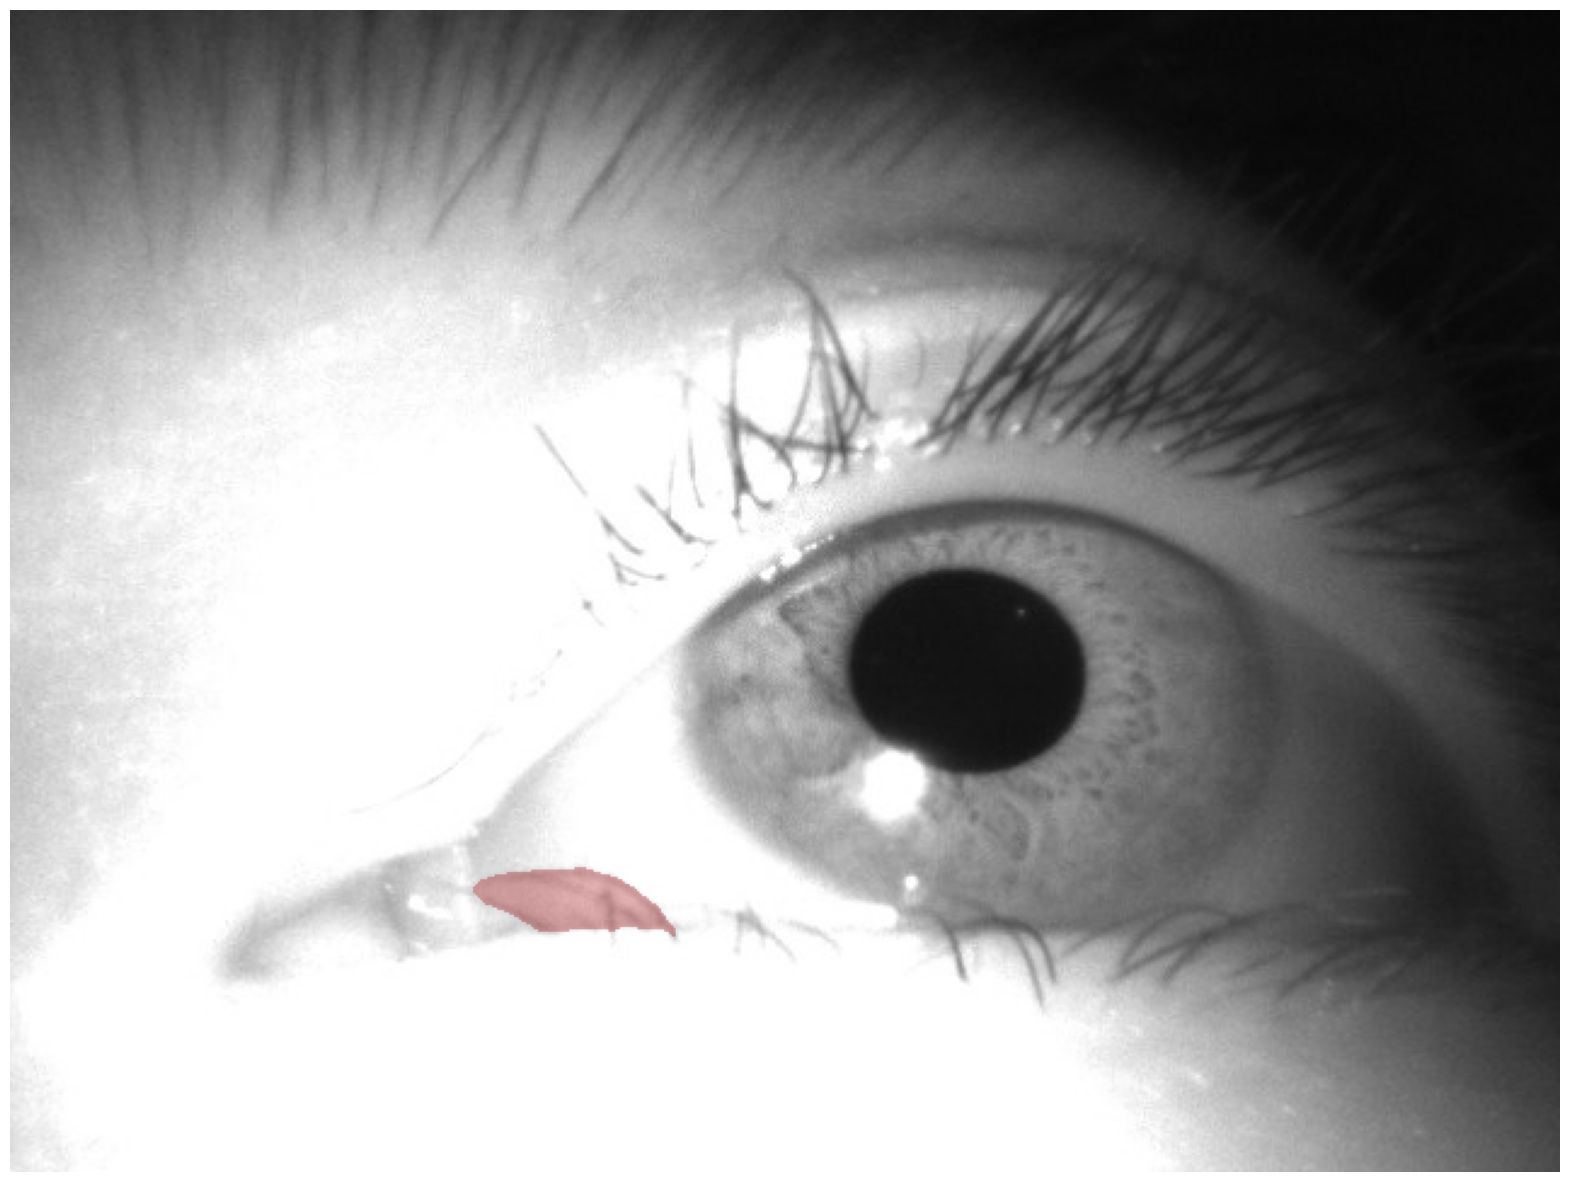

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,20))
plt.imshow(image)
#plt.imshow(np.zeros_like(image))
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
def mask_iou(mask1: np.ndarray, mask2: np.ndarray):
    """Calculate the IoU score between two segmentation masks
    Args:
        mask1: 1st segmentation mask
        mask2: 2nd segmentation mask
    """
    if len(mask1.shape) == 3:
        mask1 = mask1.sum(axis=-1)
    if len(mask2.shape) == 3:
        mask2 = mask2.sum(axis=-1)
    area1 = cv2.countNonZero((mask1 > 0).astype(int))
    area2 = cv2.countNonZero((mask2 > 0).astype(int))
    if area1 == 0 or area2 == 0:
        return 0
    area_union = cv2.countNonZero(((mask1 + mask2) > 0).astype(int))
    area_inter = area1 + area2 - area_union
    return area_inter / area_union

In [ ]:
gt = cv2.imread('/content/S1/02/3.png', cv2.IMREAD_GRAYSCALE)
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
mask_iou(sorted_anns[1]['segmentation'], gt)

0.9171249762943297

###eval and utils

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
from google.colab.patches import cv2_imshow
sam = sam_model_registry["vit_h"](checkpoint="/content/drive/MyDrive/Colab Notebooks/CV/final/sam_vit_h_4b8939.pth")
sam.to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def find_ans(img):

  image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  masks = mask_generator.generate(image)
  masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

  confidence = 0
  seg = np.zeros_like(masks[0]['segmentation'])
  for ann in masks:
    if ann['area'] > 6800 or ann['area'] < 2500:
      continue
    else:
      confidence = 1
      seg = ann['segmentation']
      break
    
  return seg, confidence

In [ ]:
def find_ans2(img):

  image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  masks = mask_generator.generate(image)
  masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

  confidence = 0
  seg = np.zeros_like(masks[0]['segmentation'])
  for ann in masks:
    if ann['area'] > 6800 or ann['area'] < 2500:
      continue
    else:
      confidence = 1
      seg = ann['segmentation']
      break
    
  return seg, confidence

In [ ]:
import numpy as np


def alpha_blend(input_image: np.ndarray, segmentation_mask: np.ndarray, alpha: float = 0.5):
    """Alpha Blending utility to overlay segmentation masks on input images
    Args:
        input_image: a np.ndarray with 1 or 3 channels
        segmentation_mask: a np.ndarray with 3 channels
        alpha: a float value
    """
    if len(input_image.shape) == 2:
        input_image = np.stack((input_image,) * 3, axis=-1)
    blended = input_image.astype(np.float32) * alpha + segmentation_mask.astype(np.float32) * (1 - alpha)
    blended = np.clip(blended, 0, 255)
    blended = blended.astype(np.uint8)
    return blended


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.sum = 0
        self.count = 0

    def reset(self):
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val
        self.count += 1

    def avg(self):
        return self.sum / self.count


# if __name__ == '__main__':
#     import os
#     import cv2
#     import matplotlib
#     import matplotlib.pyplot as plt
#     dataset_path = r'D:\CV23S_Ganzin_final_project\dataset\public\S1\01'
#     nr_image = len([name for name in os.listdir(dataset_path) if name.endswith('.jpg')])
#     print(nr_image)
#     image = cv2.imread(os.path.join(dataset_path, '0.jpg'))
#     h = image.shape[0]
#     w = image.shape[1]
#     dpi = matplotlib.rcParams['figure.dpi']
#     fig = plt.figure(figsize=(w / dpi, h / dpi))
#     ax = fig.add_axes([0, 0, 1, 1])
#     for idx in range(nr_image):
#         image_name = os.path.join(dataset_path, f'{idx}.jpg')
#         label_name = os.path.join(dataset_path, f'{idx}.png')
#         image = cv2.imread(image_name)
#         label = cv2.imread(label_name)
#         blended = alpha_blend(image, label, 0.5)
#         ax.clear()
#         ax.imshow(blended)
#         ax.axis('off')
#         plt.draw()
#         plt.pause(0.01)
#     plt.close()

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm

def true_negative_curve(confs: np.ndarray, labels: np.ndarray, nr_thresholds: int = 1000):
    """Compute true negative rates
    Args:
        confs: the algorithm outputs
        labels: the ground truth labels
        nr_thresholds: number of splits for sliding thresholds

    Returns:

    """
    thresholds = np.linspace(0, 1, nr_thresholds)
    tn_rates = []
    for th in thresholds:
        # thresholding
        predict_negatives = (confs < th).astype(int)
        # true negative
        tn = np.sum((predict_negatives * (1 - labels) > 0).astype(int))
        tn_rates.append(tn / np.sum(1 - labels))
    return np.array(tn_rates)


def mask_iou(mask1: np.ndarray, mask2: np.ndarray):
    """Calculate the IoU score between two segmentation masks
    Args:
        mask1: 1st segmentation mask
        mask2: 2nd segmentation mask
    """
    if len(mask1.shape) == 3:
        mask1 = mask1.sum(axis=-1)
    if len(mask2.shape) == 3:
        mask2 = mask2.sum(axis=-1)
    area1 = cv2.countNonZero((mask1 > 0).astype(int))
    area2 = cv2.countNonZero((mask2 > 0).astype(int))
    if area1 == 0 or area2 == 0:
        return 0
    area_union = cv2.countNonZero(((mask1 + mask2) > 0).astype(int))
    area_inter = area1 + area2 - area_union
    return area_inter / area_union


def benchmark(dataset_path: str, subjects: list):
    """Compute the weighted IoU and average true negative rate
    Args:
        dataset_path: the dataset path
        subjects: a list of subject names

    Returns: benchmark score

    """
    iou_meter = AverageMeter()
    iou_meter_sequence = AverageMeter()
    label_validity = []
    output_conf = []
    sequence_idx = 0
    for subject in subjects:
        for action_number in range(26):
            image_folder = os.path.join(dataset_path, subject, f'{action_number + 1:02d}')
            sequence_idx += 1
            nr_image = len([name for name in os.listdir(image_folder) if name.endswith('.jpg')])
            iou_meter_sequence.reset()
            label_name = os.path.join(image_folder, '0.png')
            if not os.path.exists(label_name):
                print(f'Labels are not available for {image_folder}')
                continue
            for idx in tqdm(range(nr_image), desc=f'[{sequence_idx:03d}] {image_folder}'):
                image_name = os.path.join(image_folder, f'{idx}.jpg')
                label_name = os.path.join(image_folder, f'{idx}.png')
                image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
                label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)
                # TODO: Modify the code below to run your method or load your results from disk
                output, conf = find_ans(image)
                # output = label
                # conf = 1.0
                if np.sum(label.flatten()) > 0:
                    label_validity.append(1.0)
                    iou = mask_iou(output, label)
                    iou_meter.update(conf * iou)
                    print("idx:",idx, "conf * iou:", conf * iou)
                    iou_meter_sequence.update(conf * iou)
                else:  # empty ground truth label
                    print("idx:", idx)
                    label_validity.append(0.0)
                output_conf.append(conf)
            print(f'[{sequence_idx:03d}] Weighted IoU: {iou_meter_sequence.avg()}')
    tn_rates = true_negative_curve(np.array(output_conf), np.array(label_validity))
    wiou = iou_meter.avg()
    atnr = np.mean(tn_rates)
    score = 0.7 * wiou + 0.3 * atnr
    print(f'\n\nOverall weighted IoU: {wiou:.4f}')
    print(f'Average true negative rate: {atnr:.4f}')
    print(f'Benchmark score: {score:.4f}')

    return score


# if __name__ == '__main__':
#     dataset_path = r'D:\CV23_Ganzin_final_project\dataset\public'
#     subjects = ['S1', 'S2', 'S3', 'S4']
#     benchmark(dataset_path, subjects)


In [ ]:
dataset_path = '/content'
subjects = ['S1']
benchmark(dataset_path, subjects)

In [ ]:
##01/92(反光?) 02/56~61,113~120 122(反光) 146(半開但label給完整圓形) 

### TEST

In [ ]:
import cv2
gray = cv2.imread('/content/S1/02/4.jpg', cv2.IMREAD_GRAYSCALE)
index_of_ill = (gray < 255) & (gray > 240)
gray[index_of_ill] = 0

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) # sorting segmentation masks based on the area
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    i = 0
    for ann in sorted_anns:
        i += 1
        if i != 5:
          continue
        m = ann['segmentation']
        print(ann['area'])
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
from google.colab.patches import cv2_imshow
sam = sam_model_registry["vit_h"](checkpoint="/content/drive/MyDrive/Colab Notebooks/CV/final/sam_vit_h_4b8939.pth")
sam.to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam)

gray = cv2.imread('/content/S1/02/20.jpg', cv2.IMREAD_GRAYSCALE)
#index_of_ill = (gray < 255) & (gray > 240)
#gray[index_of_ill] = 0
image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

masks = mask_generator.generate(image)

In [ ]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 277086,
  'bbox': [0, 3, 639, 474],
  'predicted_iou': 1.0136287212371826,
  'point_coords': [[10.0, 457.5]],
  'stability_score': 0.9682481288909912,
  'crop_box': [0, 0, 640, 480]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 6398,
  'bbox': [340, 287, 89, 90],


In [ ]:
biggest = -1
for i in gray[masks[1]['segmentation']]:
  if i > biggest:
    biggest = i

print(biggest)

255


6398


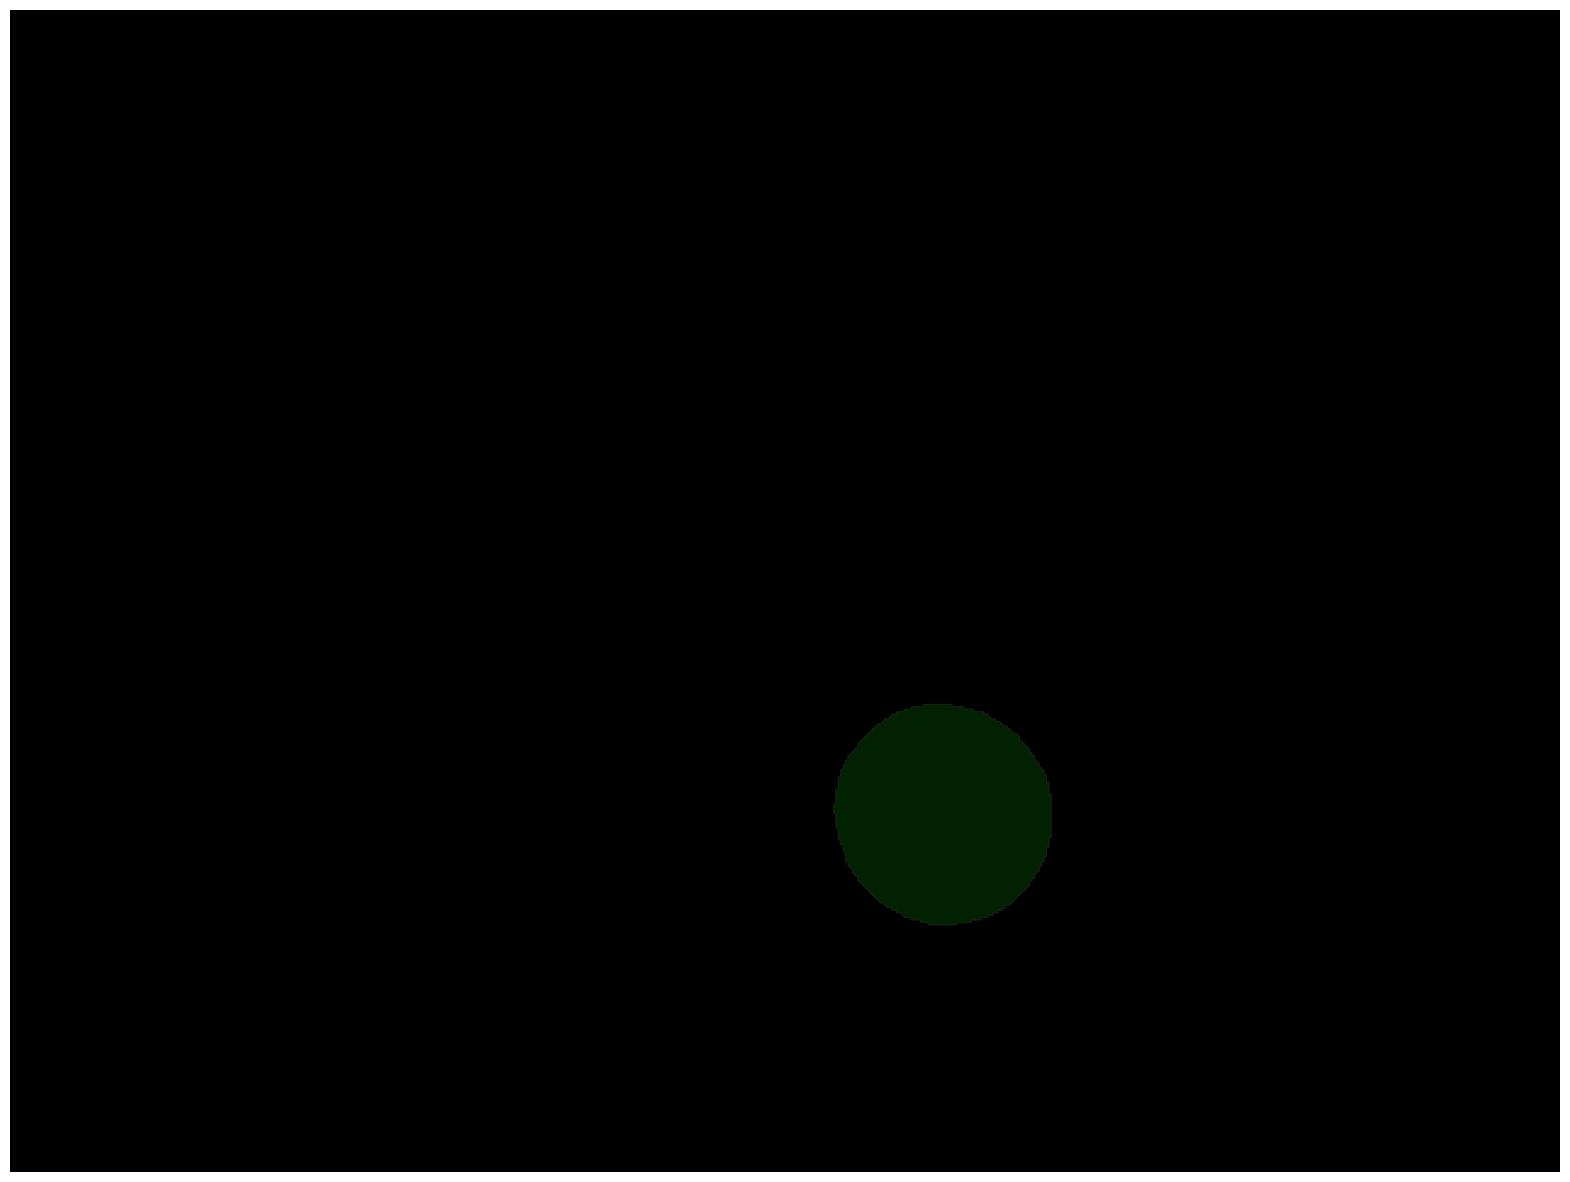

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,20))
#plt.imshow(image)
plt.imshow(np.zeros_like(image))
show_anns(masks)
plt.axis('off')
plt.show() 